### Import Libraries

In [2]:
import os
import random
import math
import time
import copy
import timm
import shap
from PIL import Image
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models , datasets
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau



from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

import albumentations as A
from albumentations.pytorch import ToTensorV2

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


### Define Path

In [ ]:
from pathlib import Path
BASE = Path("/kaggle/input/chest-xray-pneumoniacovid19tuberculosis")
assert BASE.exists(), f"{BASE} not found. Make sure dataset is added to Kaggle notebook."

train_dir = BASE / "train"
val_dir   = BASE / "val"
test_dir  = BASE / "test"

transform = transforms.ToTensor()


train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

CLASSES = sorted([p.name for p in train_dir.iterdir() if p.is_dir()])
print("Classes:", CLASSES)
print("Train counts:")
for c in CLASSES:
    p = train_dir / c
    print(f"  {c}: {len(list(p.glob('*')))}")


Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']
Train counts:
  COVID19: 460
  NORMAL: 1341
  PNEUMONIA: 3875
  TURBERCULOSIS: 650


### Define Transfromation

In [ ]:
# Dataset wrapper using Albumentations
class CXRDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        for cls in classes:
            cls_path = self.root_dir / cls
            if not cls_path.exists():
                continue
            for img_name in sorted(os.listdir(cls_path)):
                if img_name.startswith('.'):
                    continue
                self.samples.append((str(cls_path / img_name), self.class_to_idx[cls]))
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = np.array(Image.open(img_path).convert("RGB"))
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented["image"]
        return img, label, img_path


TRAIN_AUG = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.85, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Affine(scale=(0.95, 1.05), translate_percent=(0.02, 0.02), rotate=(-10, 10), p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.CLAHE(clip_limit=2.0, p=0.3),
    A.CoarseDropout(
        num_holes_range=(3, 6),
        hole_height_range=(10, 20),
        hole_width_range=(10, 20),
        fill="random_uniform",
        p=0.4
    ),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


VAL_AUG = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])


### Load dataset

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_ds = CXRDataset(train_dir, CLASSES, transform=TRAIN_AUG)
val_ds   = CXRDataset(val_dir, CLASSES, transform=VAL_AUG)
test_ds  = CXRDataset(test_dir, CLASSES, transform=VAL_AUG)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Dataset sizes -> Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))




Dataset sizes -> Train: 6326 Val: 38 Test: 771


### class names and sample counts

In [ ]:
print("Classes:", train_dataset.classes)
for cls, idx in train_dataset.class_to_idx.items():
    path = os.path.join(train_dir, cls)
    print(f"{cls}: {len(os.listdir(path))} images")

print("------------------------------------------------")
print("Classes:", val_dataset.classes)
for cls, idx in val_dataset.class_to_idx.items():
    path = os.path.join(val_dir, cls)
    print(f"{cls}: {len(os.listdir(path))} images")
print("------------------------------------------------")
print("Classes:", test_dataset.classes)
for cls, idx in test_dataset.class_to_idx.items():
    path = os.path.join(test_dir, cls)
    print(f"{cls}: {len(os.listdir(path))} images")


Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']
COVID19: 460 images
NORMAL: 1341 images
PNEUMONIA: 3875 images
TURBERCULOSIS: 650 images
------------------------------------------------
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']
COVID19: 10 images
NORMAL: 8 images
PNEUMONIA: 8 images
TURBERCULOSIS: 12 images
------------------------------------------------
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']
COVID19: 106 images
NORMAL: 234 images
PNEUMONIA: 390 images
TURBERCULOSIS: 41 images


### Show Some Samples form Dataset

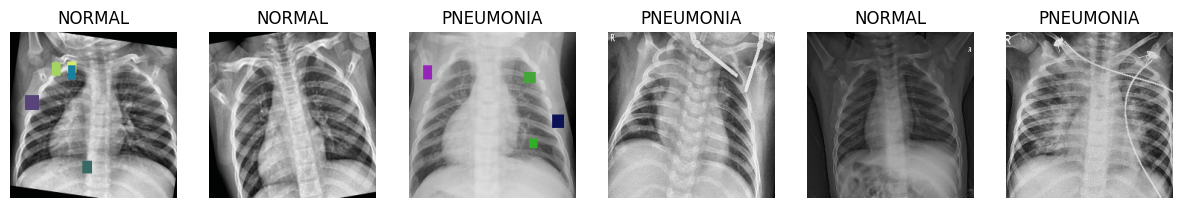

In [ ]:
def show_samples(loader, classes, n=6):
    imgs = []
    labels = []
    for x, y, p in loader:
        imgs.append(x)
        labels += list(y.numpy())
        if len(labels) >= n:
            break
    imgs = torch.cat(imgs, dim=0)[:n]
    fig, axes = plt.subplots(1, n, figsize=(15,4))
    for i in range(n):
        img = imgs[i].permute(1,2,0).cpu().numpy()
        img = (img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))
        img = np.clip(img, 0,1)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(classes[labels[i]])
    plt.show()

show_samples(train_loader, CLASSES)


### Show Classes Distribution as Histogram (Images Count)

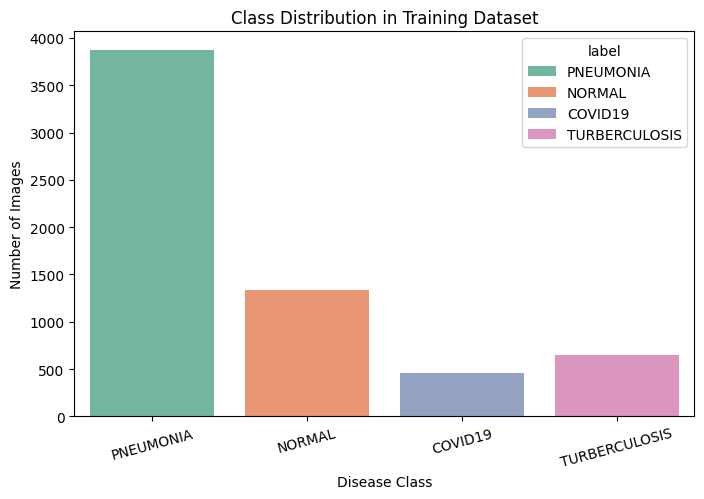

In [ ]:
data_records = []

for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        data_records.append({"label": folder, "count": num_images})

df = pd.DataFrame(data_records)

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="label", y="count", hue="label", palette="Set2", dodge=False)
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Disease Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.show()


In [ ]:
NUM_CLASSES = len(CLASSES)

model2 = models.densenet121(weights='IMAGENET1K_V1')

for param in model2.features.parameters():
    param.requires_grad = False

in_features = model2.classifier.in_features
model2.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, NUM_CLASSES)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)
print("Model running on:", device)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 141MB/s]


Model running on: cuda


### Using A pre-Build Model (EfficientNet_B0)

In [ ]:
NUM_CLASSES = len(CLASSES)

model = timm.create_model("efficientnet_b0", pretrained=True)
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier.in_features, NUM_CLASSES)
).to(device)

model = model.to(device)


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
# Compute class weights
labels = [label for _, label in train_ds.samples]
class_weights = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)




Class weights: tensor([3.4380, 1.1793, 0.4081, 2.4331], device='cuda:0')


### Defining Training

In [ ]:
import time
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion, scaler, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels, _ in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    avg_loss = total_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc


def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels, _ in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

    avg_loss = total_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc




In [ ]:
EPOCHS = 10
scaler = torch.amp.GradScaler('cuda')
best_acc = 0.0
patience = 3
counter = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(EPOCHS):
    start_time = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    scheduler.step(val_acc)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.3f}")
    print(f"Time: {(time.time()-start_time)/60:.2f} min")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
            'history': history
        }, "best_model.pth")
        print(f" Saved new best model (Val Acc: {best_acc:.3f})")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(" Early stopping triggered — no improvement.")
            break

print("\nTraining complete. Best validation accuracy:", best_acc)



Epoch [1/10]
Train Loss: 0.9800 | Train Acc: 0.620
Val   Loss: 0.5298 | Val   Acc: 0.789
Time: 1.19 min
 Saved new best model (Val Acc: 0.789)



Epoch [2/10]
Train Loss: 0.5613 | Train Acc: 0.881
Val   Loss: 0.3563 | Val   Acc: 0.842
Time: 0.96 min
 Saved new best model (Val Acc: 0.842)



Epoch [3/10]
Train Loss: 0.4827 | Train Acc: 0.931
Val   Loss: 0.3533 | Val   Acc: 0.868
Time: 0.95 min
 Saved new best model (Val Acc: 0.868)



Epoch [4/10]
Train Loss: 0.4464 | Train Acc: 0.946
Val   Loss: 0.3207 | Val   Acc: 0.921
Time: 0.96 min
 Saved new best model (Val Acc: 0.921)



Epoch [5/10]
Train Loss: 0.4383 | Train Acc: 0.952
Val   Loss: 0.3473 | Val   Acc: 0.895
Time: 0.96 min



Epoch [6/10]
Train Loss: 0.4254 | Train Acc: 0.956
Val   Loss: 0.3025 | Val   Acc: 0.947
Time: 0.96 min
 Saved new best model (Val Acc: 0.947)



Epoch [7/10]
Train Loss: 0.4166 | Train Acc: 0.966
Val   Loss: 0.2887 | Val   Acc: 0.947
Time: 0.97 min



Epoch [8/10]
Train Loss: 0.4081 | Train Acc: 0.965
Val   Loss: 0.3095 | Val   Acc: 0.921
Time: 0.95 min



Epoch [9/10]
Train Loss: 0.4055 | Train Acc: 0.969
Val   Loss: 0.2885 | Val   Acc: 0.921
Time: 0.93 min
 Early stopping triggered — no improvement.

Training complete. Best validation accuracy: 0.9473684210526315


### Plot Training & Validation History

Plotting training and validation history...


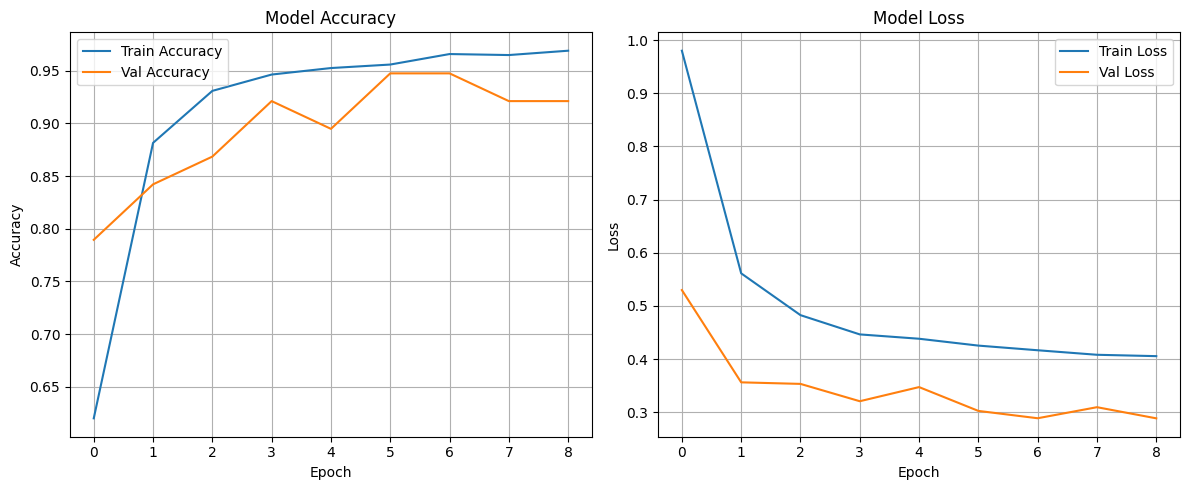

Loading best model from 'best_model.pth' for testing...
Best model loaded and set to eval mode.


In [ ]:
print("Plotting training and validation history...")

plt.figure(figsize=(12, 5))
# plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


print("Loading best model from 'best_model.pth' for testing...")

model_test = timm.create_model("efficientnet_b0", pretrained=False)
model_test.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model_test.classifier.in_features, NUM_CLASSES)
)

checkpoint = torch.load("best_model.pth")
model_test.load_state_dict(checkpoint['model_state_dict'])

model_test = model_test.to(device)
model_test.eval()

print("Best model loaded and set to eval mode.")

### Showing Confusion Matrix

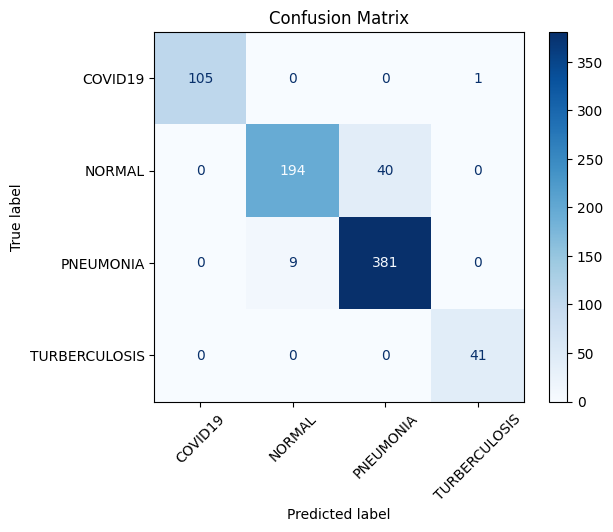


Classification Report:
               precision    recall  f1-score   support

      COVID19       1.00      0.99      1.00       106
       NORMAL       0.96      0.83      0.89       234
    PNEUMONIA       0.90      0.98      0.94       390
TURBERCULOSIS       0.98      1.00      0.99        41

     accuracy                           0.94       771
    macro avg       0.96      0.95      0.95       771
 weighted avg       0.94      0.94      0.93       771



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels, _ in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model_test(imgs)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))


### Ploting ROC Curve per Class

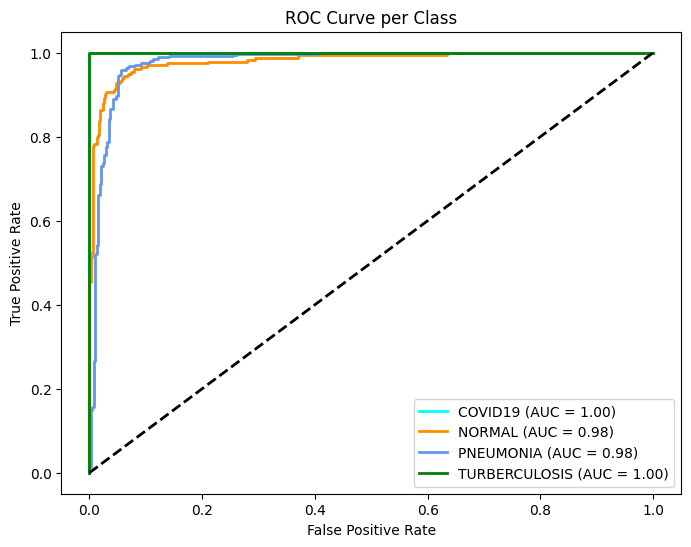

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

y_true_bin = label_binarize(y_true, classes=list(range(len(CLASSES))))
y_score = []

with torch.no_grad():
    for imgs, labels, _ in test_loader:
        imgs = imgs.to(device)
        outputs = torch.softmax(model_test(imgs), dim=1)
        y_score.extend(outputs.cpu().numpy())

y_score = np.array(y_score)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(CLASSES)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "red", "purple"])
for i, color in zip(range(len(CLASSES)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{CLASSES[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class")
plt.legend(loc="lower right")
plt.show()


### Making Prediction On test Set

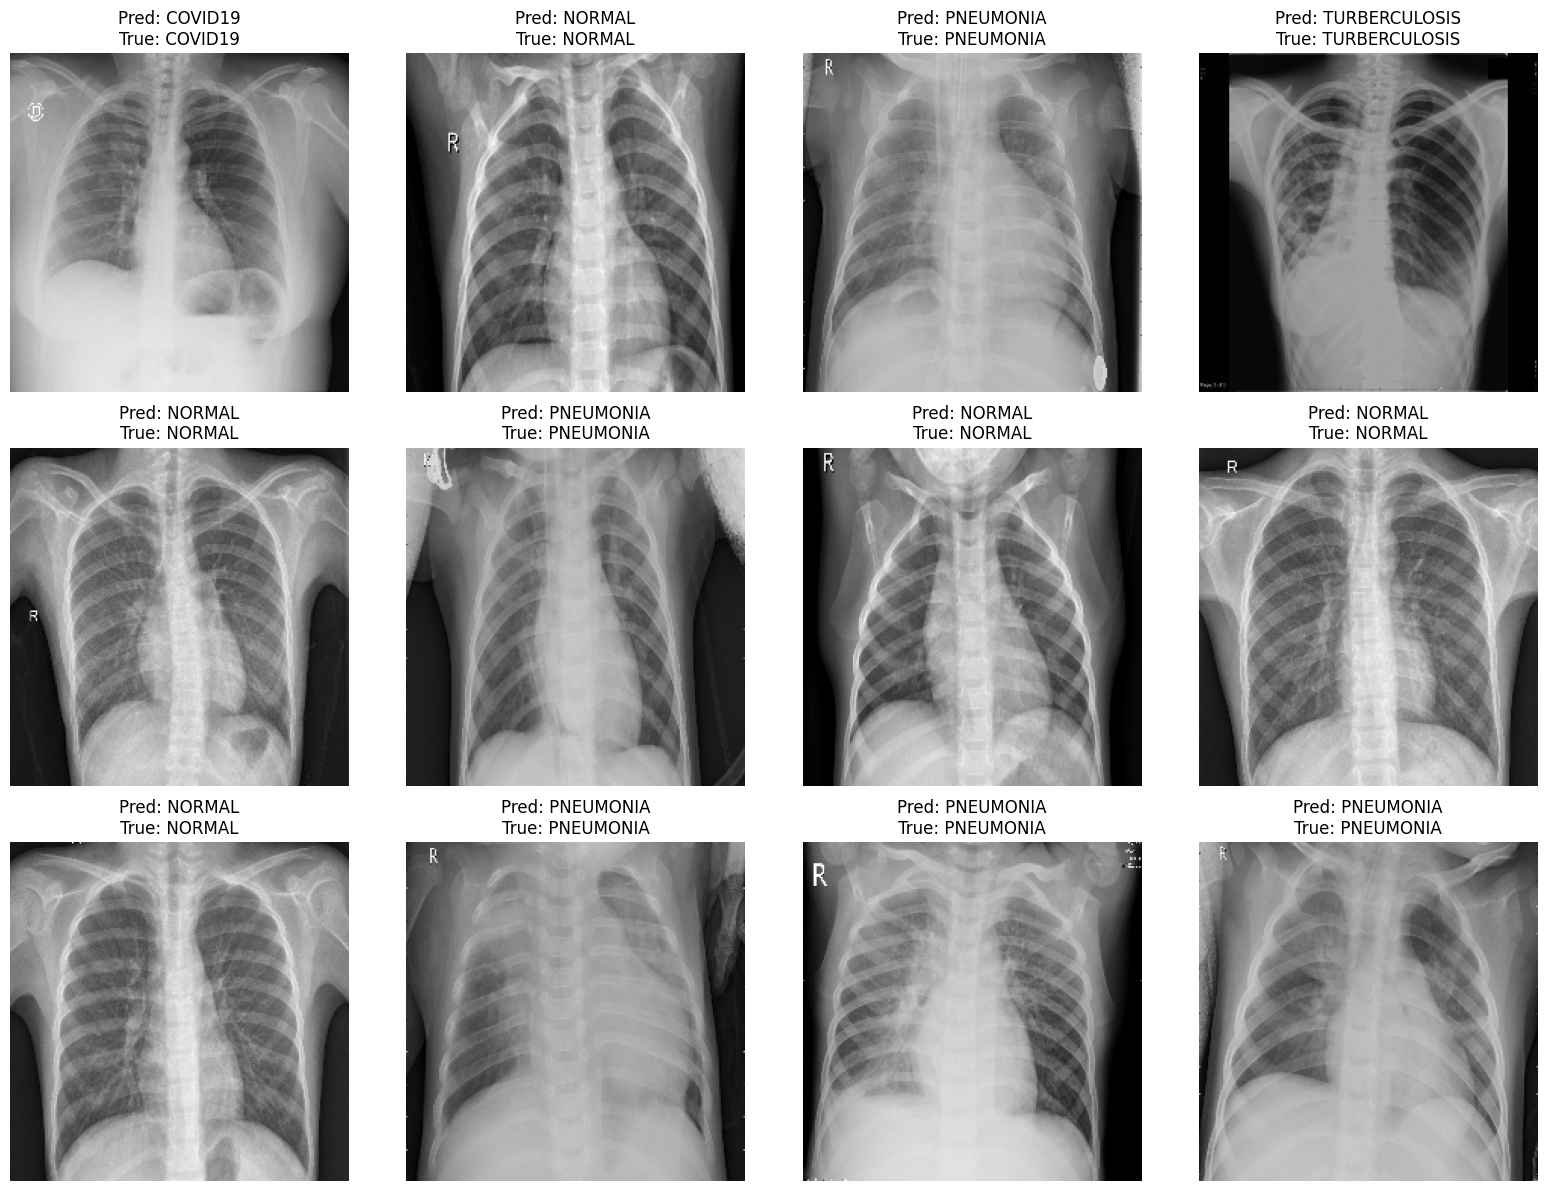

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

num_images = 12
class_samples = []

for cls_idx, cls_name in enumerate(CLASSES):
    cls_indices = [i for i, (_, label) in enumerate(test_ds.samples) if label == cls_idx]
    sample_idx = random.choice(cls_indices)
    class_samples.append(sample_idx)

remaining = num_images - len(class_samples)
all_indices = sorted(set(range(len(test_ds))) - set(class_samples))
class_samples += random.sample(all_indices, remaining)

imgs = []
labels = []
for idx in class_samples:
    img, label, _ = test_ds[idx]
    imgs.append(img.unsqueeze(0))
    labels.append(label)

imgs = torch.cat(imgs, dim=0).to(device)
labels = torch.tensor(labels).to(device)

with torch.no_grad():
    outputs = model_test(imgs)
    preds = torch.softmax(outputs, dim=1)
    pred_classes = preds.argmax(dim=1)
    true_classes = labels

plt.figure(figsize=(16, 12))
for i in range(num_images):
    plt.subplot(3, 4, i+1)
    img = imgs[i].cpu().numpy().transpose(1,2,0)
    img = (img * np.array([0.229,0.224,0.225])) + np.array([0.485,0.456,0.406])
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.title(f"Pred: {CLASSES[pred_classes[i]]}\nTrue: {CLASSES[true_classes[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
